# Halo Seeding Tests
---

The idea behind this is to make a function which takes the Vpeak of the halos from Tyler's sims and then Seeds them with a galaxy randomly based on the Vmax function from the isolated dwarfs, this will probably give you way too few galaxies, reguardless of your halo limit you adopt.

We can solve this two ways:

1) Change the Vmax function

2) There's some sort of redshift evolution we don't understand

In [2]:
%pylab inline
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sys, os, re
from scipy.special import erf
from scipy.optimize import curve_fit
from andrew_tools.simple_tools import high_low_limit
import Claires_modules

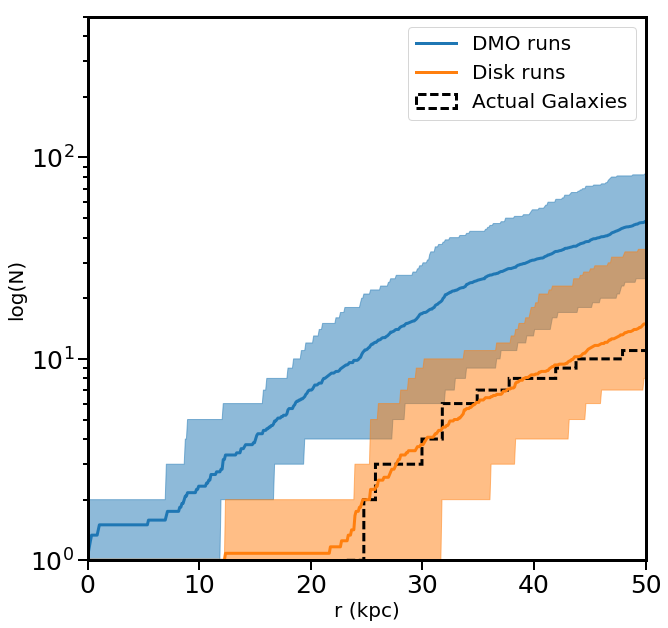

In [3]:
#okay first lets just reproduce the old radial functions

h = 0.6751

n_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    #print data_file
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    R_vir_host = Data_Rvir[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    #print distances_from_center
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,100.0,1001))
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):

    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,100.0,1001))
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,100.0,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C1',label='Disk runs')

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

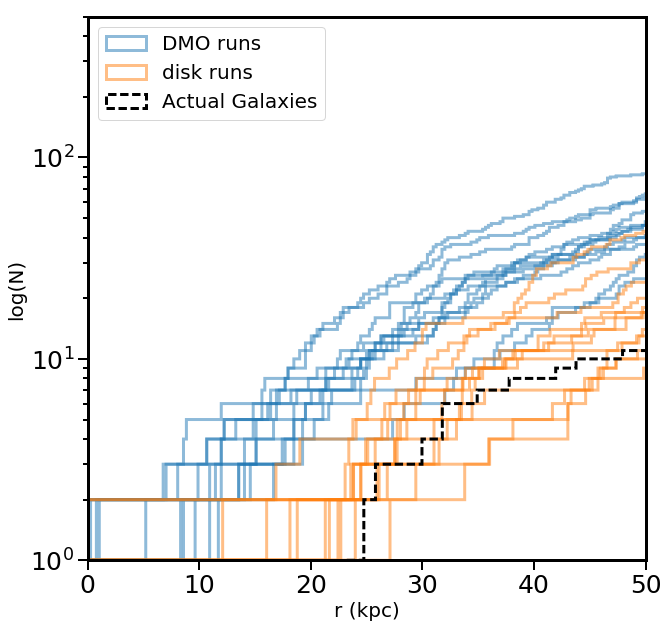

In [4]:
#radial functions of individual halos

n_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'))

all_hist_matrix = np.zeros((n_files,1000)) 

n_iter = 0

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS//Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]*1000.0/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h

    Vmax_mask = (Data_M>8.0)

    Data_cens_cut = Data_cens[Vmax_mask]
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    host_cen = Data_cens_cut[host_index]
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0')
    
    all_hist_c = np.cumsum(all_hist)
    all_hist_matrix[n_iter] = all_hist_c
    n_iter += 1

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'))

disk_hist_matrix = np.zeros((disk_files,1000)) 

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>M_t)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])
    
    #print Data_cens_cut
    
    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    disk_hist, disk_bins = np.histogram(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001))
    plt.hist(distances_from_center,bins=np.linspace(0.0,R_vir_host,1001),cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1')
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,R_vir_host,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C0',label='DMO runs')
plt.hist([],cumulative=True,histtype='step',linewidth=3,alpha=0.5,color='C1',label='disk runs')
plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.legend(loc=2, prop={'size': 20})
#plt.savefig('./initial_figures/all_halos_individual.png',bbox_inches='tight')
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:92: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


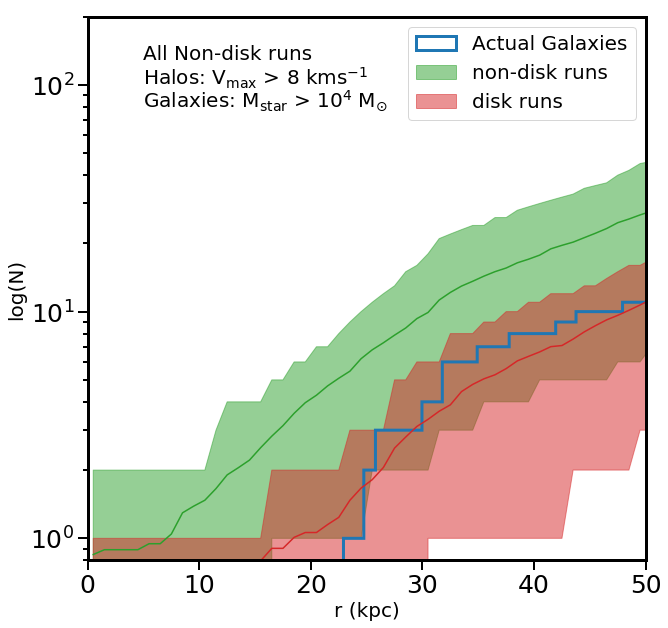

In [9]:
#okay now the compilation of all the sims observed with mock SDSS and
#DES like surveys

h = 0.6751

total_len = 0
total_hist = None

disk_total_len = 0
disk_total_hist = None

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_Data/'):
    f_halos = h5py.File('../../initial_test_with_ELVIS/Tyler_Data/'+data_file)
    halo_name = data_file.split('_')[2]
    #print halo_name
    Data_M = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Vmax'][:]
    Data_Mass = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Mvir'][:]/h
    Data_cens = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Center'][:]/h
    Data_X = Data_cens[:,0]
    Data_Y = Data_cens[:,1]
    Data_Z = Data_cens[:,2]
    Data_Rvir = f_halos['Snapshot00152']['HaloCatalog_Rockstar']['Rvir'][:]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix, radius_bins = Claires_modules.calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW, Andr)
        
    if total_hist == None:
        total_hist = hist_matrix
    else:
        total_hist = np.concatenate((total_hist,hist_matrix),axis=0)
    
    total_len += len(hist_matrix)

plot_bins = [(radius_bins[ii]+radius_bins[ii+1])*1000.0/2.0 for ii in range(len(radius_bins)-1)]

min_line = [np.min(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
max_line = [np.max(total_hist[:,ii]) for ii in range(len(total_hist[0]))]
med_line = [np.mean(total_hist[:,ii]) for ii in range(len(total_hist[0]))]

hl_line = [high_low_limit(total_hist[:,ii],0.68) for ii in range(len(total_hist[0]))]

low_line = [xx[0] for xx in hl_line]
high_line = [xx[1] for xx in hl_line]

plot_top = max_line[-1]

# Now do the same for the disk runs

for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data/'+data_file)
    halo_name = re.split('_|\.',str(data_file))[2]
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]/h
    Data_Y = f_halos[:,1]/h
    Data_Z = f_halos[:,2]/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    
    M_t = 8.0
    
    Vmax_mask = (Data_M>8.0)
    
    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    
    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    
    Andr = 0
    MW = host_index

    hist_matrix, radius_bins = Claires_modules.calc_corr_factors(Data_X_cut, Data_Y_cut, Data_Z_cut, Data_M_cut, Data_Rvir_cut, MW, Andr)
        
    if disk_total_hist == None:
        disk_total_hist = hist_matrix
    else:
        disk_total_hist = np.concatenate((disk_total_hist,hist_matrix),axis=0)
    
    disk_total_len += len(hist_matrix)

disk_min_line = [np.min(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_max_line = [np.max(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]
disk_med_line = [np.mean(disk_total_hist[:,ii]) for ii in range(len(disk_total_hist[0]))]

disk_hl_line = [high_low_limit(disk_total_hist[:,ii],0.68) for ii in range(len(disk_total_hist[0]))]

disk_low_line = [xx[0] for xx in disk_hl_line]
disk_high_line = [xx[1] for xx in disk_hl_line]


f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
#print large_gal_dist

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([0.8,200.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
plt.yscale('log')

plt.text(5.0,130.0,'All Non-disk runs',fontsize=20)
plt.text(5.0,100.0,'Halos: $V_{max}$ > 8 $kms^{-1}$',fontsize=20)
plt.text(5.0,80.0,'Galaxies: $M_{star}$ > $10^4$ $M_{\odot}$',fontsize=20)

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,label='Actual Galaxies')

plt.fill_between(plot_bins,low_line,high_line,color='C2',alpha=0.5,label='non-disk runs')
plt.plot(plot_bins,med_line,color='C2')

plt.fill_between(plot_bins,disk_low_line,disk_high_line,color='C3',alpha=0.5,label='disk runs')
plt.plot(plot_bins,disk_med_line,color='C3')

#plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
plt.savefig('./radial_projections.png',bbox_inches='tight')
plt.show()

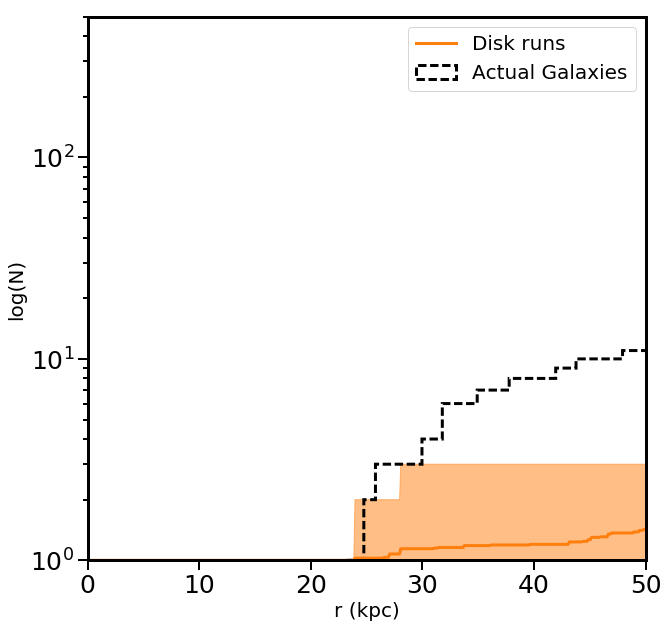

In [6]:
#begin by applying the filter to just the radial functions
#without a radial correction

#okay here are the vmax bins, I might eventually fit a function
#actually I should just fit a function

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#now if I use a normalized cdf the fit parameters are sigma = 2.66718967  mu = 20.98533531 for Vmax

popt = [2.66718967, 20.98533531]

h = 0.6751

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

disk_hist_matrix = np.zeros((disk_files*10,1000)) 

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    for kk in range(10):
        
        f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
        Data_M = f_halos[:,3]
        Data_X = f_halos[:,0]*1000.0/h
        Data_Y = f_halos[:,1]*1000.0/h
        Data_Z = f_halos[:,2]*1000.0/h
        Data_Rvir = f_halos[:,5]/h
        Data_Mass = f_halos[:,4]/h
        Data_Vpeak = f_halos[:,6]

        M_t = 8.0

        Vmax_mask = (Data_M>M_t)

        Data_X_cut = Data_X[Vmax_mask]
        Data_Y_cut = Data_Y[Vmax_mask]
        Data_Z_cut = Data_Z[Vmax_mask]
        Data_M_cut = Data_M[Vmax_mask]
        filled_frac = normal_cdf(Data_M_cut,*popt)
        Data_Rvir_cut = Data_Rvir[Vmax_mask]
        Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
        Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

        host_index = np.argmax(Data_M_cut)
        R_vir_host = Data_Rvir_cut[host_index]
        host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

        coord_dist = Data_cens_cut - host_cen
        distances_from_center = np.linalg.norm(coord_dist,axis=1)

        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])

        #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)
        
        disk_hist, disk_bins = np.histogram(distances_from_center[weighted_coin_flip],bins=np.linspace(0.0,100.0,1001))
        disk_hist_c = np.cumsum(disk_hist)
        disk_hist_matrix[disk_iter] = disk_hist_c
        disk_iter += 1
    
r_list = np.linspace(0.0,100.0,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
#min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C1',label='Disk runs')

plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

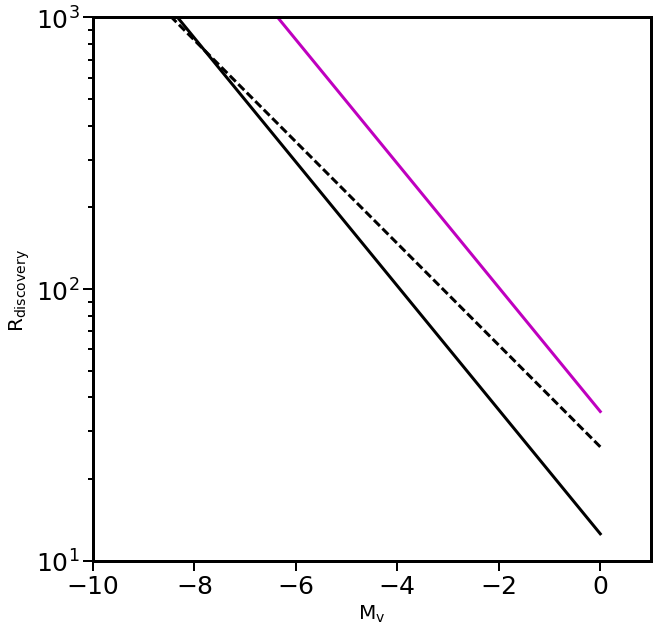

In [25]:
def R_comp(Mv,a,b):
    R_comp = 10.0**(-a*Mv-b)
    #R_comp = (3.0*V_comp/(4.0*np.pi))**1.0/3.0
    return R_comp

Mv_thing = -1.6

Mv_list = np.linspace(0.0,-18.0,100)

SDSS_k_line = [R_comp(xx,0.228,1.90)*1000.0 for xx in Mv_list]
SDSS_w_line = [R_comp(xx,0.187,1.58)*1000.0 for xx in Mv_list]
DES_line = [R_comp(xx,0.228,1.45)*1000.0 for xx in Mv_list]

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([-10.0,1.0])
plt.ylim([10.0,1000.0])
plt.xlabel('$M_{v}$',fontsize=20)
plt.ylabel('$R_{discovery}$',fontsize=20)

plt.plot(Mv_list,SDSS_k_line,color='k',linewidth=3)
plt.plot(Mv_list,SDSS_w_line,color='k',linestyle='--',linewidth=3)
plt.plot(Mv_list,DES_line,color='m',linewidth=3)

plt.legend(loc=1, prop={'size': 20})
plt.yscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

9.43545574695 7.00516334637


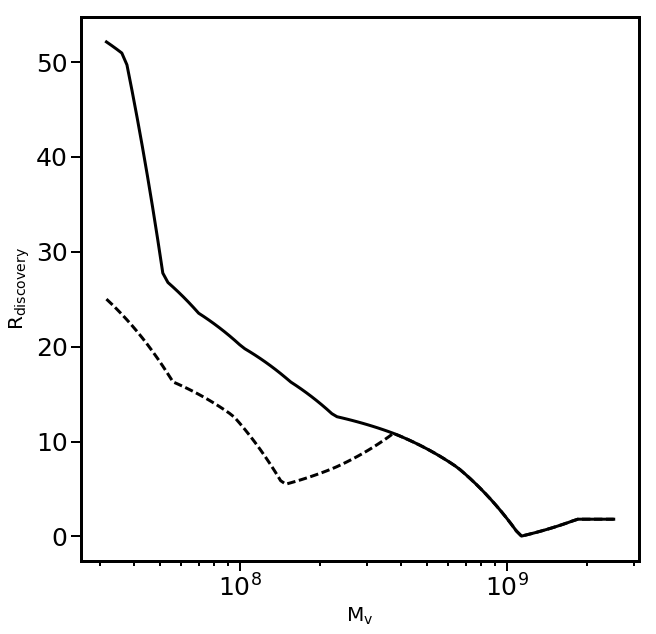

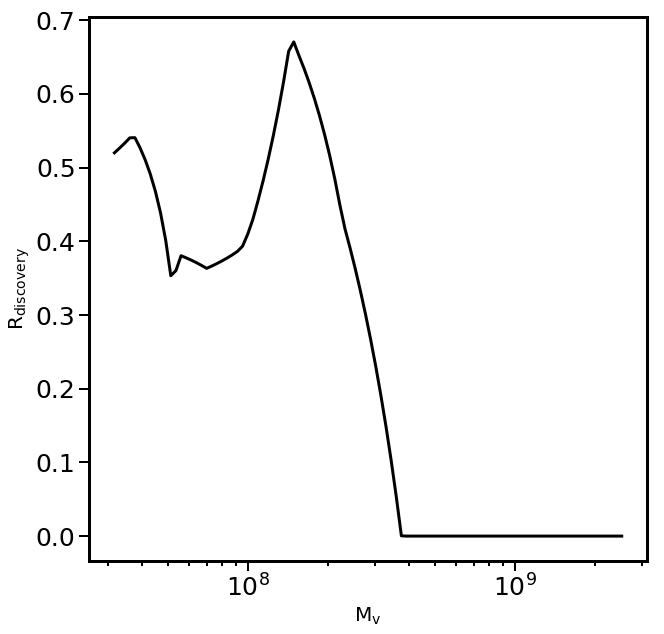

In [58]:
from scipy import interpolate

f_Ferah_all = np.loadtxt('/Users/andrewgraus/Work/Alternative_physics_runs/papers/Munshi_all_cumulative.txt')
f_Ferah_gal = np.loadtxt('/Users/andrewgraus/Work/Alternative_physics_runs/papers/Munshi_gal_cumulative.txt')

diff_all = [f_Ferah_all[:,1][ii+1]-f_Ferah_all[:,1][ii] for ii in range(len(f_Ferah_all[:,1])-1)]
diff_gal = [f_Ferah_gal[:,1][ii+1]-f_Ferah_gal[:,1][ii] for ii in range(len(f_Ferah_gal[:,1])-1)]

M_all = [f_Ferah_all[:,0][ii] for ii in range(len(f_Ferah_all[:,1])-1)]
M_gal = [f_Ferah_gal[:,0][ii] for ii in range(len(f_Ferah_gal[:,1])-1)]

interp_gal = interpolate.interp1d(M_gal,diff_gal)
interp_all = interpolate.interp1d(M_all,diff_all)

print np.log10(np.max([M_gal[0],M_all[0]])),np.log10(np.min([M_gal[-1],M_all[-1]]))

M_list = np.logspace(7.5,9.4,100)
diff_all_interp = interp_all(M_list)
diff_gal_interp = interp_gal(M_list)

dark_ratio = diff_gal_interp/diff_all_interp

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([-10.0,1.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$M_{v}$',fontsize=20)
plt.ylabel('$R_{discovery}$',fontsize=20)

#plt.plot(f_Ferah_all[:,0], f_Ferah_all[:,1],color='k',linewidth=3)
#plt.plot(f_Ferah_gal[:,0],f_Ferah_gal[:,1],color='k',linestyle='--',linewidth=3)

plt.plot(M_list,diff_all_interp,color='k',linewidth=3)
plt.plot(M_list,diff_gal_interp,color='k',linestyle='--',linewidth=3)

plt.legend(loc=1, prop={'size': 20})
plt.xscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')

plt.figure(2,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([-10.0,1.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$M_{v}$',fontsize=20)
plt.ylabel('$R_{discovery}$',fontsize=20)

#plt.plot(f_Ferah_all[:,0], f_Ferah_all[:,1],color='k',linewidth=3)
#plt.plot(f_Ferah_gal[:,0],f_Ferah_gal[:,1],color='k',linestyle='--',linewidth=3)

plt.plot(M_list,1.0-dark_ratio,color='k',linewidth=3)

plt.legend(loc=1, prop={'size': 20})
plt.xscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

[1.29431369 8.25455603]


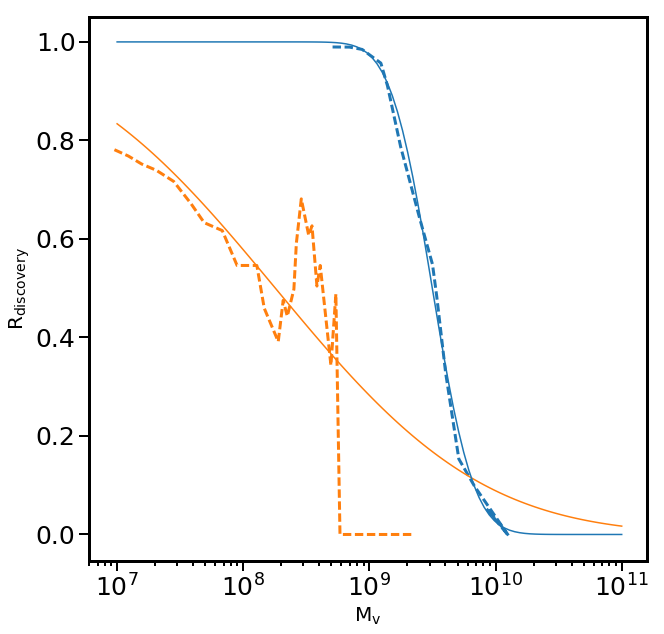

In [14]:
#dark fraction compilation

def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((-x+mu)/(sigma*np.sqrt(2.0))))

M_h_me = [  1.00000000e+07,   1.46779927e+07,   2.15443469e+07,   3.16227766e+07,
   4.64158883e+07,   6.81292069e+07,   1.00000000e+08,   1.46779927e+08,
   2.15443469e+08,   3.16227766e+08,   4.64158883e+08,   6.81292069e+08,
   1.00000000e+09,   1.46779927e+09,   2.15443469e+09,   3.16227766e+09,
   4.64158883e+09,   6.81292069e+09,   1.00000000e+10,   1.46779927e+10,
   2.15443469e+10,   3.16227766e+10,   4.64158883e+10,   6.81292069e+10,
   1.00000000e+11]

f_l_me = [ 0.,          0.99777778,  0.99844961,  0.99754702,  0.99883856,  0.99827586,
  0.98717949,  0.98770492,  0.97560976,  0.97029703,  0.92105263,  0.89655172,
  0.83870968,  0.72222222,  0.16666667,  0.16666667,  0.,          0.,          0.,
  0.,          0.,          0.,          0.,          0.        ]

M_h_me = [(M_h_me[xx]+M_h_me[xx+1])/2.0 for xx in range(len(M_h_me)-1)]

f_Sawala = np.loadtxt('/Users/andrewgraus/Work/Alternative_physics_runs/papers/Sawala_dark_fraction.txt')
f_BL = np.loadtxt('/Users/andrewgraus/Work/Alternative_physics_runs/papers/BL_dark_fraction')
f_Munshi = np.loadtxt('/Users/andrewgraus/Work/Alternative_physics_runs/papers/Munshi_4b.txt')

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([-10.0,1.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$M_{v}$',fontsize=20)
plt.ylabel('$R_{discovery}$',fontsize=20)

popt_BL, pcov_BL = curve_fit(normal_cdf,np.log10(f_BL[:,0]),f_BL[:,1],p0=[1.0,9.5])
popt_M, pcov_M = curve_fit(normal_cdf,np.log10(f_Munshi[:,0]),1.0-f_Munshi[:,1],p0=[2.0,7.0])

mass_list = np.linspace(7.0,11.0,100)
BL_fit = normal_cdf(mass_list,*popt_BL)
M_fit = normal_cdf(mass_list,*popt_M)

m_l_plot = np.power(10.0,mass_list)

#plt.plot(M_h_me,f_l_me,color='k',linewidth=3,linestyle='--')
#plt.plot(f_Sawala[:,0],1.0-f_Sawala[:,1],color='m',linewidth=3,linestyle='--')
plt.plot(f_BL[:,0],f_BL[:,1],color='C0',linewidth=3,linestyle='--')
plt.plot(f_Munshi[:,0],1.0-f_Munshi[:,1],color='C1',linewidth=3,linestyle='--')
#plt.plot(M_list,1.0-dark_ratio,color='C1',linewidth=3)

plt.plot(m_l_plot,M_fit,color='C1')
plt.plot(m_l_plot,BL_fit,color='C0')

plt.legend(loc=1, prop={'size': 20})
plt.xscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

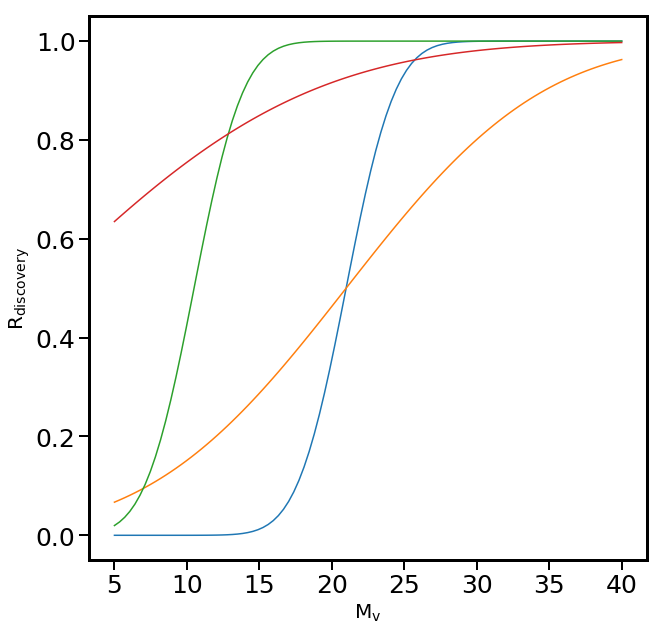

In [6]:
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

v_max_fit = np.linspace(5.0,40.0,100)

popt = [2.66718967, 20.98533531]
popt_wide = [2.66718967*4.0, 20.98533531]
popt_low = [2.66718967, 20.98533531/2.0]
popt_bad = [14.5,0.0]

orig_fit = normal_cdf(v_max_fit,*popt)
wide_fit = normal_cdf(v_max_fit,*popt_wide)
low_fit = normal_cdf(v_max_fit,*popt_low)
bad_fit = normal_cdf(v_max_fit,*popt_bad)

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([-10.0,1.0])
#plt.ylim([10.0,1000.0])
plt.xlabel('$M_{v}$',fontsize=20)
plt.ylabel('$R_{discovery}$',fontsize=20)

plt.plot(v_max_fit,orig_fit,color='C0')
plt.plot(v_max_fit,wide_fit,color='C1')
plt.plot(v_max_fit,low_fit,color='C2')
plt.plot(v_max_fit,bad_fit,color='C3')

#plt.legend(loc=1, prop={'size': 20})
#plt.xscale('log')
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


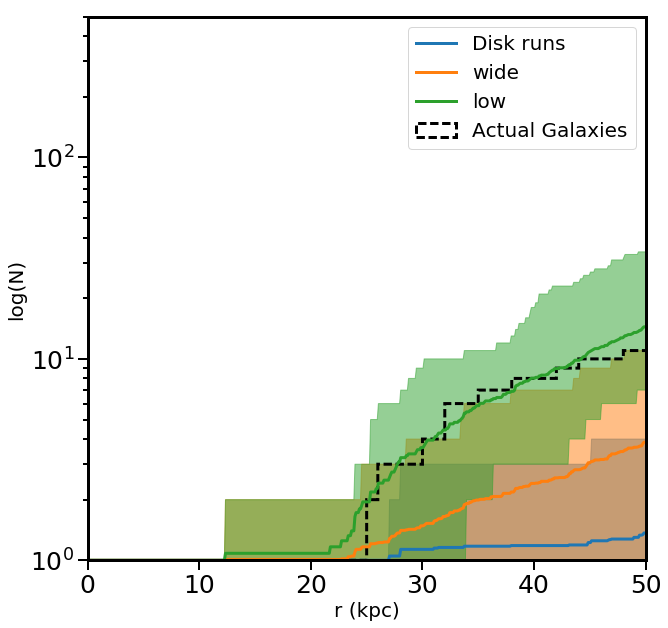

In [74]:
#begin by applying the filter to just the radial functions
#without a radial correction

#okay here are the vmax bins, I might eventually fit a function
#actually I should just fit a function

%load_ext line_profiler

%lprun
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#now if I use a normalized cdf the fit parameters are sigma = 2.66718967  mu = 20.98533531 for Vmax

popt = [2.66718967, 20.98533531]
popt_wide = [2.66718967*4.0, 20.98533531]
popt_low = [2.66718967, 5.0]

h = 0.6751

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

disk_hist_matrix = np.zeros((disk_files*10,1000)) 
wide_hist_matrix = np.zeros((disk_files*10,1000)) 
low_hist_matrix = np.zeros((disk_files*10,1000))

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    for kk in range(10):
        
        f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
        Data_M = f_halos[:,3]
        Data_X = f_halos[:,0]*1000.0/h
        Data_Y = f_halos[:,1]*1000.0/h
        Data_Z = f_halos[:,2]*1000.0/h
        Data_Rvir = f_halos[:,5]/h
        Data_Mass = f_halos[:,4]/h
        Data_Vpeak = f_halos[:,6]

        M_t = 8.0

        Vmax_mask = (Data_M>M_t)

        Data_X_cut = Data_X[Vmax_mask]
        Data_Y_cut = Data_Y[Vmax_mask]
        Data_Z_cut = Data_Z[Vmax_mask]
        Data_M_cut = Data_M[Vmax_mask]
        filled_frac = normal_cdf(Data_M_cut,*popt)
        Data_Rvir_cut = Data_Rvir[Vmax_mask]
        Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
        Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

        host_index = np.argmax(Data_M_cut)
        R_vir_host = Data_Rvir_cut[host_index]
        host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

        coord_dist = Data_cens_cut - host_cen
        distances_from_center = np.linalg.norm(coord_dist,axis=1)

        filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
        filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
        filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)
        
        weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
        weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
        weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])
        
        #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)
        
        disk_hist, disk_bins = np.histogram(distances_from_center[weighted_coin_flip],bins=np.linspace(0.0,100.0,1001))
        disk_hist_c = np.cumsum(disk_hist)
        disk_hist_matrix[disk_iter] = disk_hist_c
        
        wide_hist, wide_bins = np.histogram(distances_from_center[weighted_coin_flip_wide],bins=np.linspace(0.0,100.0,1001))
        wide_hist_c = np.cumsum(wide_hist)
        wide_hist_matrix[disk_iter] = wide_hist_c
        
        low_hist, low_bins = np.histogram(distances_from_center[weighted_coin_flip_low],bins=np.linspace(0.0,100.0,1001))
        low_hist_c = np.cumsum(low_hist)
        low_hist_matrix[disk_iter] = low_hist_c
        disk_iter += 1
    
r_list = np.linspace(0.0,100.0,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
#min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

wide_min_line = [np.min(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_max_line = [np.max(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_med_line = [np.mean(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]

low_min_line = [np.min(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_max_line = [np.max(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_med_line = [np.mean(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C0',label='Disk runs')

plt.fill_between(r_list_plot,wide_min_line,wide_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,wide_med_line,linewidth=3,color='C1',label='wide')

plt.fill_between(r_list_plot,low_min_line,low_max_line,color='C2',alpha=0.5)
plt.plot(r_list_plot,low_med_line,linewidth=3,color='C2',label='low')

#plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')
data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_list,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

In [ ]:
#NOTE: This is a revision of the above program to see if this gives the same answer

#In the above program what I do is take each simulation and then iterate 10 times on it and then the average
#of ALL those runs is computed

#In this version I'm going to take all the sims and calculate the average, and then apply the dark fraction
#to this. In principle this should be slightly faster, and if it's not any different more useable for the
#other version of this code

%timeit
def normal_cdf(x,sigma,mu):
    return 0.5*(1.0+erf((x-mu)/(sigma*np.sqrt(2.0))))

#now if I use a normalized cdf the fit parameters are sigma = 2.66718967  mu = 20.98533531 for Vmax

popt = [2.66718967, 20.98533531]
popt_wide = [2.66718967*4.0, 20.98533531]
popt_low = [2.66718967, 5.0]

h = 0.6751

disk_files = len(os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'))

disk_hist_matrix = np.zeros((disk_files*10,1000)) 
wide_hist_matrix = np.zeros((disk_files*10,1000)) 
low_hist_matrix = np.zeros((disk_files*10,1000))

disk_iter = 0
    
for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
    f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
    Data_M = f_halos[:,3]
    Data_X = f_halos[:,0]*1000.0/h
    Data_Y = f_halos[:,1]*1000.0/h
    Data_Z = f_halos[:,2]*1000.0/h
    Data_Rvir = f_halos[:,5]/h
    Data_Mass = f_halos[:,4]/h
    Data_Vpeak = f_halos[:,6]

    M_t = 8.0

    Vmax_mask = (Data_M>M_t)

    Data_X_cut = Data_X[Vmax_mask]
    Data_Y_cut = Data_Y[Vmax_mask]
    Data_Z_cut = Data_Z[Vmax_mask]
    Data_M_cut = Data_M[Vmax_mask]
    filled_frac = normal_cdf(Data_M_cut,*popt)
    Data_Rvir_cut = Data_Rvir[Vmax_mask]
    Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
    Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

    host_index = np.argmax(Data_M_cut)
    R_vir_host = Data_Rvir_cut[host_index]
    host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

    coord_dist = Data_cens_cut - host_cen
    distances_from_center = np.linalg.norm(coord_dist,axis=1)
    
    all_hist, all_bins = 
    
disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

    filled_frac = normal_cdf(Data_Vpeak_cut,*popt)
    filled_frac_wide = normal_cdf(Data_Vpeak_cut,*popt_wide)
    filled_frac_low = normal_cdf(Data_Vpeak_cut,*popt_low)

    weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])
    weighted_coin_flip_wide = np.array([True if random.random() < xx else False for xx in filled_frac_wide])
    weighted_coin_flip_low = np.array([True if random.random() < xx else False for xx in filled_frac_low])

    #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)

    disk_hist, disk_bins = np.histogram(distances_from_center[weighted_coin_flip],bins=np.linspace(0.0,100.0,1001))
    disk_hist_c = np.cumsum(disk_hist)
    disk_hist_matrix[disk_iter] = disk_hist_c

    wide_hist, wide_bins = np.histogram(distances_from_center[weighted_coin_flip_wide],bins=np.linspace(0.0,100.0,1001))
    wide_hist_c = np.cumsum(wide_hist)
    wide_hist_matrix[disk_iter] = wide_hist_c

    low_hist, low_bins = np.histogram(distances_from_center[weighted_coin_flip_low],bins=np.linspace(0.0,100.0,1001))
    low_hist_c = np.cumsum(low_hist)
    low_hist_matrix[disk_iter] = low_hist_c
    disk_iter += 1
    
r_list = np.linspace(0.0,100.0,1001)
    
r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]
#min_line = [np.min(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#max_line = [np.max(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]
#med_line = [np.mean(all_hist_matrix[:,ii]) for ii in range(len(all_hist_matrix[0]))]

disk_min_line = [np.min(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_max_line = [np.max(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]
disk_med_line = [np.mean(disk_hist_matrix[:,ii]) for ii in range(len(disk_hist_matrix[0]))]

wide_min_line = [np.min(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_max_line = [np.max(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]
wide_med_line = [np.mean(wide_hist_matrix[:,ii]) for ii in range(len(wide_hist_matrix[0]))]

low_min_line = [np.min(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_max_line = [np.max(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]
low_med_line = [np.mean(low_hist_matrix[:,ii]) for ii in range(len(low_hist_matrix[0]))]

f_dat = np.loadtxt('../../Sats_data.csv',delimiter=',',dtype=object)
gal_dist = np.asarray([float(xx) for xx in f_dat[:,1]])
gal_mass = np.asarray([float(xx) for xx in f_dat[:,2]])

large_gal_mask = (gal_mass>1.0e4)&(gal_dist<R_vir_host)

large_gal_dist = gal_dist[large_gal_mask]
    
plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
plt.xlim([0.0,50.0])
plt.ylim([1.0,500.0])
plt.xlabel('r (kpc)',fontsize=20)
plt.ylabel('log(N)',fontsize=20)
#plt.fill_between(r_list_plot,min_line,max_line,color='C0',alpha=0.5)
#plt.plot(r_list_plot,med_line,linewidth=3,color='C0',label='DMO runs')

plt.fill_between(r_list_plot,disk_min_line,disk_max_line,color='C0',alpha=0.5)
plt.plot(r_list_plot,disk_med_line,linewidth=3,color='C0',label='Disk runs')

plt.fill_between(r_list_plot,wide_min_line,wide_max_line,color='C1',alpha=0.5)
plt.plot(r_list_plot,wide_med_line,linewidth=3,color='C1',label='wide')

plt.fill_between(r_list_plot,low_min_line,low_max_line,color='C2',alpha=0.5)
plt.plot(r_list_plot,low_med_line,linewidth=3,color='C2',label='low')

#plt.hist(gal_dist,bins=np.linspace(0.0,R_vir_host,1000),cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')
data_hist, data_bins, data_patches = plt.hist(gal_dist,bins=r_list,cumulative=True,histtype='step',linewidth=3,color='k',linestyle='--',label='Actual Galaxies')

plt.yscale('log')
plt.legend(loc=1, prop={'size': 20})
#plt.savefig('./all_halos_shade.png',bbox_inches='tight')
plt.show()

In [79]:
import scipy.stats

print len(disk_med_line), len(data_hist)

ks_fid = scipy.stats.ks_2samp(data_hist,disk_med_line)
ks_wide = scipy.stats.ks_2samp(data_hist,wide_med_line)
ks_low = scipy.stats.ks_2samp(data_hist,low_med_line)

print ks_fid[0], ks_wide[0], ks_low

1000 1000
0.68 0.397 Ks_2sampResult(statistic=0.33499999999999996, pvalue=1.038118699173028e-49)


In [82]:
#parameter test
#I'm going to initate a grid of parameters and then test what
#fits the distribution best

mu_list = np.linspace(5.0,40.0,5)
sigma_list = np.linspace(1.0,8.0,5)

ks_all,p_val = [],[]

for mu_select in mu_list:
    for sigma_select in sigma_list:
        popt = [sigma_select,mu_select]
        select_hist_matrix = np.zeros((disk_files*10,1000)) 

        print 'mu: {}, sigma: {}'.format(mu_select,sigma_select)
        
        select_iter = 0

        for data_file in os.listdir('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'):
            for kk in range(10):

                f_halos = np.loadtxt('../../initial_test_with_ELVIS/Tyler_disk_data_from_mt/'+data_file)
                Data_M = f_halos[:,3]
                Data_X = f_halos[:,0]*1000.0/h
                Data_Y = f_halos[:,1]*1000.0/h
                Data_Z = f_halos[:,2]*1000.0/h
                Data_Rvir = f_halos[:,5]/h
                Data_Mass = f_halos[:,4]/h
                Data_Vpeak = f_halos[:,6]

                M_t = 8.0

                Vmax_mask = (Data_M>M_t)

                Data_X_cut = Data_X[Vmax_mask]
                Data_Y_cut = Data_Y[Vmax_mask]
                Data_Z_cut = Data_Z[Vmax_mask]
                Data_M_cut = Data_M[Vmax_mask]
                filled_frac = normal_cdf(Data_M_cut,*popt)
                Data_Rvir_cut = Data_Rvir[Vmax_mask]
                Data_cens_cut = np.vstack((Data_X_cut,Data_Y_cut,Data_Z_cut)).T
                Data_Vpeak_cut = Data_Vpeak[Vmax_mask]

                host_index = np.argmax(Data_M_cut)
                R_vir_host = Data_Rvir_cut[host_index]
                host_cen = np.array([Data_X_cut[host_index],Data_Y_cut[host_index],Data_Z_cut[host_index]])

                coord_dist = Data_cens_cut - host_cen
                distances_from_center = np.linalg.norm(coord_dist,axis=1)

                filled_frac = normal_cdf(Data_Vpeak_cut,*popt)

                weighted_coin_flip = np.array([True if random.random() < xx else False for xx in filled_frac])

                #print len(Data_X), np.sum(Vmax_mask), np.sum(weighted_coin_flip)

                select_hist, select_bins = np.histogram(distances_from_center[weighted_coin_flip],bins=np.linspace(0.0,100.0,1001))
                select_hist_c = np.cumsum(select_hist)
                select_hist_matrix[select_iter] = select_hist_c

                select_iter += 1
        
        r_list = np.linspace(0.0,100.0,1001)
        r_list_plot = [(r_list[ii]+r_list[ii+1])/2.0 for ii in range(len(r_list)-1)]

        select_med_line = [np.mean(select_hist_matrix[:,ii]) for ii in range(len(select_hist_matrix[0]))]
        ks_test = scipy.stats.ks_2samp(data_hist,select_med_line)

        print 'ks: {}'.format(ks_test[0])
        
        ks_all.append(ks_test[0])
        p_val.append(ks_test[1])

mu: 5.0, sigma: 1.0
ks: 0.342
mu: 5.0, sigma: 2.75
ks: 0.332
mu: 5.0, sigma: 4.5
ks: 0.314
mu: 5.0, sigma: 6.25
ks: 0.298
mu: 5.0, sigma: 8.0
ks: 0.276
mu: 13.75, sigma: 1.0
ks: 0.31
mu: 13.75, sigma: 2.75
ks: 0.25
mu: 13.75, sigma: 4.5
ks: 0.23
mu: 13.75, sigma: 6.25
ks: 0.23
mu: 13.75, sigma: 8.0
ks: 0.23
mu: 22.5, sigma: 1.0
ks: 0.7
mu: 22.5, sigma: 2.75
ks: 0.683
mu: 22.5, sigma: 4.5
ks: 0.68
mu: 22.5, sigma: 6.25
ks: 0.633
mu: 22.5, sigma: 8.0
ks: 0.56
mu: 31.25, sigma: 1.0
ks: 0.75
mu: 31.25, sigma: 2.75
ks: 0.75
mu: 31.25, sigma: 4.5
ks: 0.74
mu: 31.25, sigma: 6.25
ks: 0.74
mu: 31.25, sigma: 8.0
ks: 0.74
mu: 40.0, sigma: 1.0
ks: 0.75
mu: 40.0, sigma: 2.75
ks: 0.75
mu: 40.0, sigma: 4.5
ks: 0.75
mu: 40.0, sigma: 6.25
ks: 0.75
mu: 40.0, sigma: 8.0
ks: 0.75


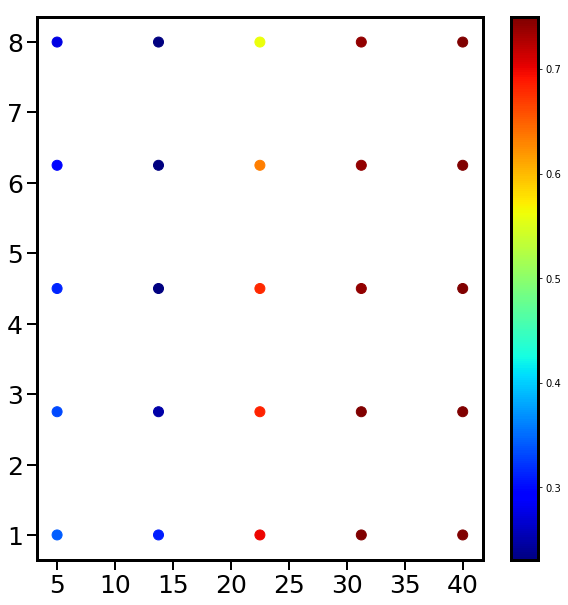

In [85]:
mu_all = []
sigma_all = []

for mu_select in mu_list:
    for sigma_select in sigma_list:
        mu_all.append(mu_select)
        sigma_all.append(sigma_select)

plt.figure(1,(10,10))
rc('axes',linewidth=3)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.tick_params(which='minor',width=2,length=5)
plt.tick_params(which='major',width=2,length=10)
#plt.xlim([0.0,50.0])
#plt.ylim([1.0,500.0])
#plt.xlabel('r (kpc)',fontsize=20)
#plt.ylabel('log(N)',fontsize=20)

plt.scatter(mu_all,sigma_all,c=ks_all,cmap='jet',s=100)
plt.colorbar()
plt.show()